# Import necessary libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict, deque
from dataclasses import dataclass, field
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import accuracy_score

# Code to combine datasets from multiple seasons

In [2]:
# Find the common columns between 2021-11.csv and 2021-2022.csv
cols1 = set(pd.read_csv("Datasets/2009-10.csv", nrows=0).columns)
cols2 = set(pd.read_csv("Datasets/2021-2022.csv", nrows=0).columns)
common_cols = sorted(cols1 & cols2)

print(f"Using {len(common_cols)} common columns:\n{common_cols}\n")

list_of_files = [
    "Datasets/2009-10.csv",
    "Datasets/2010-11.csv",
    "Datasets/2011-12.csv",
    "Datasets/2012-13.csv",
    "Datasets/2013-14.csv",
    "Datasets/2014-15.csv",
    "Datasets/2015-16.csv",
    "Datasets/2016-17.csv",
    "Datasets/2017-18.csv",
    "Datasets/2018-19.csv",
    "Datasets/2019-20.csv",
    "Datasets/2020-2021.csv",
    "Datasets/2021-2022.csv",
]

dfs = []
for fname in list_of_files:
    if not os.path.isfile(fname):
        print(f"⚠️  {fname} not found, skipping")
        continue

    df = pd.read_csv(fname)
    df = df.reindex(columns=common_cols)  # drops extras columns
    dfs.append(df)

#Concatenate and save
combined = pd.concat(dfs, ignore_index=True)
combined.to_csv("test2.csv", index=False)

print(f"Wrote all_seasons_common_cols.csv "
      f"({combined.shape[0]} rows × {combined.shape[1]} cols)")

Using 38 common columns:
['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'Referee', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH']

Wrote all_seasons_common_cols.csv (4600 rows × 38 cols)


# Code to create new features from existing features

In [3]:
h2h_past3 = defaultdict(lambda: deque(maxlen=3))
h2h_past5 = defaultdict(lambda: deque(maxlen=5))

class StandingsEntry:
    def __init__(self, team_name: str):
        self.team_name = team_name
        self.points    = 0
        self.standing  = 0

class Teamstats:
    def __init__(self, team_name, past_standing = 21):
        self.team_name = team_name
         # Rolling windows for form
        self.last5 = deque(maxlen=5)
        self.last3 = deque(maxlen=3)
         # Streak & points
        self.streak = 0
        self.streak_type = 0  # 1 for win, -1 for loss, 0 for draw
        self.current_points = 0
         # Season totals
        self.games_played = 0
        self.total_goals = 0
        self.total_shots = 0
        self.total_shots_on_target = 0
        self.total_corners = 0
        self.total_fouls = 0
        # Opponent stats
        self.total_goals_against = 0
        self.total_shots_against = 0
        self.total_shots_on_target_against = 0
        self.total_corners_against = 0
        self.total_fouls_against = 0
        # Last two cards
        self.reds_last_two = deque(maxlen=2)
        self.yellows_last_two = deque(maxlen=2)
        # Past season finish 
        self.past_standing = past_standing
       
        
    def new_season(self):
        # cards and points
        self.reds_last_two.clear()
        self.yellows_last_two.clear()
        self.current_points = 0
        # season totals
        self.games_played = 0
        self.total_goals = 0
        self.total_goals_against = 0
        self.total_shots = 0
        self.total_shots_on_target = 0
        self.total_corners = 0
        self.total_fouls = 0 
        # opponent stats
        self.total_goals_against = 0
        self.total_shots_against = 0
        self.total_shots_on_target_against = 0
        self.total_corners_against = 0
        self.total_fouls_against = 0
        # past season finish
        pass
    
    def get_streak(self, result):    
        if result == self.streak_type:
            self.streak += result
        else:
            self.streak = result
            self.streak_type = result
            
    def get_points(self, result):
        if result == 1:
            self.current_points += 3
        elif result == 0:
            self.current_points += 1
    
    def add_game(
        self,goals_for,goals_against,shots_for,shots_against,sot_for,sot_against,corners_for,corners_against,fouls_for,fouls_against,reds,yellows,result):
        # Totals for and against
        self.total_goals           += goals_for
        self.total_goals_against   += goals_against
        self.total_shots           += shots_for
        self.total_shots_against   += shots_against
        self.total_shots_on_target += sot_for
        self.total_shots_on_target_against += sot_against
        self.total_corners         += corners_for
        self.total_corners_against += corners_against
        self.total_fouls           += fouls_for
        self.total_fouls_against   += fouls_against
        # Cards
        self.reds_last_two.append(reds)
        self.yellows_last_two.append(yellows)
        # Games and form deques
        self.games_played += 1
        self.last5.append(result)
        self.last3.append(result)
        # Streak and points
        self.get_streak(result)
        self.get_points(result)
        
    @property
    def past3_form(self):
        return sum(self.last3)

    @property
    def past5_form(self):
        return sum(self.last5)

    @property
    def current_streak(self):
        return self.streak

    @property
    def goals_per_game(self):
        return round(self.total_goals / self.games_played, 2) if self.games_played else 0

    @property
    def shots_per_game(self):
        return round(self.total_shots / self.games_played, 2) if self.games_played else 0

    @property
    def shots_on_target_per_game(self):
        return round(self.total_shots_on_target / self.games_played, 2) if self.games_played else 0

    @property
    def corners_per_game(self):
        return round(self.total_corners / self.games_played, 2) if self.games_played else 0

    @property
    def fouls_per_game(self):
        return round(self.total_fouls / self.games_played, 2) if self.games_played else 0

    @property
    def goals_against_per_game(self):
        return round(self.total_goals_against / self.games_played, 2) if self.games_played else 0

    @property
    def shots_against_per_game(self):
        return round(self.total_shots_against / self.games_played, 2) if self.games_played else 0

    @property
    def shots_on_target_against_per_game(self):
        return round(self.total_shots_on_target_against / self.games_played, 2) if self.games_played else 0

    @property
    def corners_against_per_game(self):
        return round(self.total_corners_against / self.games_played, 2) if self.games_played else 0

    @property
    def fouls_against_per_game(self):
        return round(self.total_fouls_against / self.games_played, 2) if self.games_played else 0

    @property
    def reds_last2(self):
        return sum(self.reds_last_two)

    @property
    def yellows_last2(self):
        return sum(self.yellows_last_two)

team_dict = {}
standings_dict = {}
    
def load_past_standings(path):
    df = pd.read_csv(path)
    # if the "2008" column has NaNs, replace them with 0 and cast to int
    df['2009'] = df['2009'].fillna(0).astype(int)

    for _, row in df.iterrows():
        pos = row['2009'] 
        if pos <= 17 and pos != 0:
            team = Teamstats(row['Team'], pos)
            team_dict[row['Team']] = team
    
def update_standings_dict(home, away, home_points, away_points):
    if home not in standings_dict:
        standings_dict[home] = StandingsEntry(home)
    standings_dict[home].points += home_points
    
    if away not in standings_dict:
        standings_dict[away] = StandingsEntry(away)
    standings_dict[away].points += away_points
    get_ranking()
    
def get_ranking():
    # Sort the standings dictionary by points and update the standing attribute for each team
    sorted_standings = sorted(standings_dict.items(),key=lambda item: item[1].points,reverse=True)
    for rank, (team_name, stats) in enumerate(sorted_standings, start=1):
        stats.standing = rank

def new_season_check(month, prevmonth):
    return month >= 8 and prevmonth <= 6

def new_season_standings():
    get_ranking()
    for team_name, entry in standings_dict.items():
        if entry.standing <= 17:
            team_dict[team_name].past_standing = entry.standing
            print(f"Team {team_name} finished in position {entry.standing} last season with {entry.points}.")
    print("New season standings loaded.")
    print(" ")
    
    standings_dict.clear()

# Load the CSV into a DataFrame
def main():
    '''corresponding game # (so its 1 to 1 with from09_sorted.csv), and then the following features for both away and home: the past 3 game form (increment vs decrement),
    past 5 game form (same thing), h2h past 5, h2h past 3, streak (increment or decrement until steak ends then becomes 1 or -1), current standing (win = +3, draw = +1, lose = 0), past season standing  (21 if NaN),  
    goals per game (total goals/games player per season), shots on target per game (same thing), shots per page (same thing), corners per game (same thing), fouls per game (same thing), 
    reds last two games , yellows last two games.'''        
    df = pd.read_csv('test2.csv')
    load_past_standings('Datasets/EPLStandings.csv')

    standings_dict.clear()
    prevmonth = None
    features_list = []

    for idx, row in df.iterrows():
        date = pd.to_datetime(row['Date'], dayfirst=True, yearfirst=False, errors='coerce')
        month = date.month

        if prevmonth and new_season_check(month, prevmonth):
            new_season_standings()
            for team in team_dict.values():
                team.new_season()

        prevmonth = month

        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        for team_name in [home_team, away_team]:
            if team_name not in team_dict:
                team_dict[team_name] = Teamstats(team_name)
            if team_name not in standings_dict:
                standings_dict[team_name] = StandingsEntry(team_name)

        home_goals = row['FTHG']
        away_goals = row['FTAG']
        result_home = 1 if home_goals > away_goals else -1 if home_goals < away_goals else 0
        result_away = -result_home

        home_points = 3 if result_home == 1 else 1 if result_home == 0 else 0
        away_points = 3 if result_away == 1 else 1 if result_away == 0 else 0
        
        home_h2h3 = sum(h2h_past3[(home_team, away_team)])
        home_h2h5 = sum(h2h_past5[(home_team, away_team)])
        away_h2h3 = sum(h2h_past3[(away_team, home_team)])
        away_h2h5 = sum(h2h_past5[(away_team, home_team)])
    
        # Build features row before updating stats
        features_row = {
            'GameNumber': idx + 1,
            'HomeTeam': home_team,
            'AwayTeam': away_team,

            # Home team features
            'Home_Past3_Form': team_dict[home_team].past3_form,
            'Home_Past5_Form': team_dict[home_team].past5_form,
            'Home_Streak': team_dict[home_team].current_streak,
            'Home_Current_Standing': standings_dict[home_team].standing,
            'Home_Past_Standing': team_dict[home_team].past_standing,
            'Home_Goals_Per_Game': team_dict[home_team].goals_per_game,
            'Home_Shots_Per_Game': team_dict[home_team].shots_per_game,
            'Home_SOT_Per_Game': team_dict[home_team].shots_on_target_per_game,
            'Home_Corners_Per_Game': team_dict[home_team].corners_per_game,
            'Home_Fouls_Per_Game': team_dict[home_team].fouls_per_game,
            'Home_Reds_Last2': team_dict[home_team].reds_last2,
            'Home_Yellows_Last2': team_dict[home_team].yellows_last2,
            'Home_Goals_Against_Per_Game': team_dict[home_team].goals_against_per_game,
            'Home_Shots_Against_Per_Game': team_dict[home_team].shots_against_per_game,
            'Home_SOT_Against_Per_Game': team_dict[home_team].shots_on_target_against_per_game,
            'Home_Corners_Against_Per_Game': team_dict[home_team].corners_against_per_game,
            'Home_Fouls_Against_Per_Game': team_dict[home_team].fouls_against_per_game,

            # Away team features
            'Away_Past3_Form': team_dict[away_team].past3_form,
            'Away_Past5_Form': team_dict[away_team].past5_form,
            'Away_Streak': team_dict[away_team].current_streak,
            'Away_Current_Standing': standings_dict[away_team].standing,
            'Away_Past_Standing': team_dict[away_team].past_standing,
            'Away_Goals_Per_Game': team_dict[away_team].goals_per_game,
            'Away_Shots_Per_Game': team_dict[away_team].shots_per_game,
            'Away_SOT_Per_Game': team_dict[away_team].shots_on_target_per_game,
            'Away_Corners_Per_Game': team_dict[away_team].corners_per_game,
            'Away_Fouls_Per_Game': team_dict[away_team].fouls_per_game,
            'Away_Goals_Against_Per_Game': team_dict[away_team].goals_against_per_game,
            'Away_Shots_Against_Per_Game': team_dict[away_team].shots_against_per_game,
            'Away_SOT_Against_Per_Game': team_dict[away_team].shots_on_target_against_per_game,
            'Away_Corners_Against_Per_Game': team_dict[away_team].corners_against_per_game,
            'Away_Fouls_Against_Per_Game': team_dict[away_team].fouls_against_per_game,
            'Away_Reds_Last2': team_dict[away_team].reds_last2,
            'Away_Yellows_Last2': team_dict[away_team].yellows_last2,
            
            # H2H features
            'Home_H2H_Past3': home_h2h3,
            'Home_H2H_Past5': home_h2h5,
            'Away_H2H_Past3': away_h2h3,
            'Away_H2H_Past5': away_h2h5,

            # Actual match results
            'Home_Goals': home_goals,
            'Away_Goals': away_goals,
            'Match_Result': result_home
        }
        
        features_list.append(features_row)
        
        h2h_past3[(home_team, away_team)].append( result_home)
        h2h_past3[(away_team, home_team)].append(-result_home)
        h2h_past5[(home_team, away_team)].append( result_home)
        h2h_past5[(away_team, home_team)].append(-result_home)

        # Update after appending
        team_dict[home_team].add_game(
            goals_for=home_goals, goals_against=away_goals,
            shots_for=row['HS'], shots_against=row['AS'],
            sot_for=row['HST'], sot_against=row['AST'],
            corners_for=row['HC'], corners_against=row['AC'],
            fouls_for=row['HF'], fouls_against=row['AF'],
            reds=row['HR'], yellows=row['HY'], result=result_home
        )

        team_dict[away_team].add_game(
            goals_for=away_goals, goals_against=home_goals,
            shots_for=row['AS'], shots_against=row['HS'],
            sot_for=row['AST'], sot_against=row['HST'],
            corners_for=row['AC'], corners_against=row['HC'],
            fouls_for=row['AF'], fouls_against=row['HF'],
            reds=row['AR'], yellows=row['AY'], result=result_away
        )

        update_standings_dict(home_team, away_team, home_points, away_points)

    # Export to CSV after all games processed
    final_features_df = pd.DataFrame(features_list)
    final_features_df.to_csv('testfeature2.csv', index=False)
    print("Feature extraction complete.") 

if __name__ == "__main__":
    main()

Team Aston Villa finished in position 6 last season with 64.
Team Wigan finished in position 16 last season with 36.
Team Blackburn finished in position 9 last season with 50.
Team Man City finished in position 5 last season with 67.
Team Bolton finished in position 14 last season with 39.
Team Sunderland finished in position 13 last season with 44.
Team Chelsea finished in position 1 last season with 86.
Team Everton finished in position 8 last season with 61.
Team Arsenal finished in position 3 last season with 75.
Team Fulham finished in position 12 last season with 46.
Team Stoke finished in position 11 last season with 47.
Team Wolves finished in position 15 last season with 38.
Team West Ham finished in position 17 last season with 35.
Team Man United finished in position 2 last season with 85.
Team Birmingham finished in position 10 last season with 50.
Team Tottenham finished in position 4 last season with 70.
Team Liverpool finished in position 7 last season with 63.
New seaso

# Split and scale dataset

In [4]:
# Load the data
df = pd.read_csv('testfeature2.csv')

# Separate features and target
X = df.drop(columns=['Home_Goals', 'Away_Goals', 'Match_Result', 'GameNumber', 'HomeTeam', 'AwayTeam'])
y = df['Match_Result']

# First split into temp_train (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then split temp into train (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Unsupervised Analysis: PCA

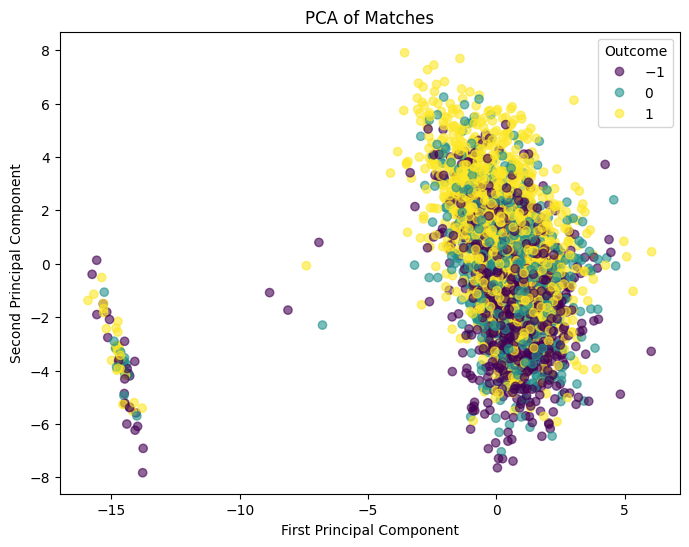

In [6]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('PCA of Matches')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()


# Logistic Regression

C=0.005, Accuracy: 0.5120
C=0.01, Accuracy: 0.5091
C=0.05, Accuracy: 0.5087
C=0.1, Accuracy: 0.5094
C=0.5, Accuracy: 0.5094
C=1, Accuracy: 0.5091
C=5, Accuracy: 0.5087
C=10, Accuracy: 0.5083
C=50, Accuracy: 0.5091

Best C: 0.005, Best CV Score: 0.5120
Test Accuracy: 0.5261


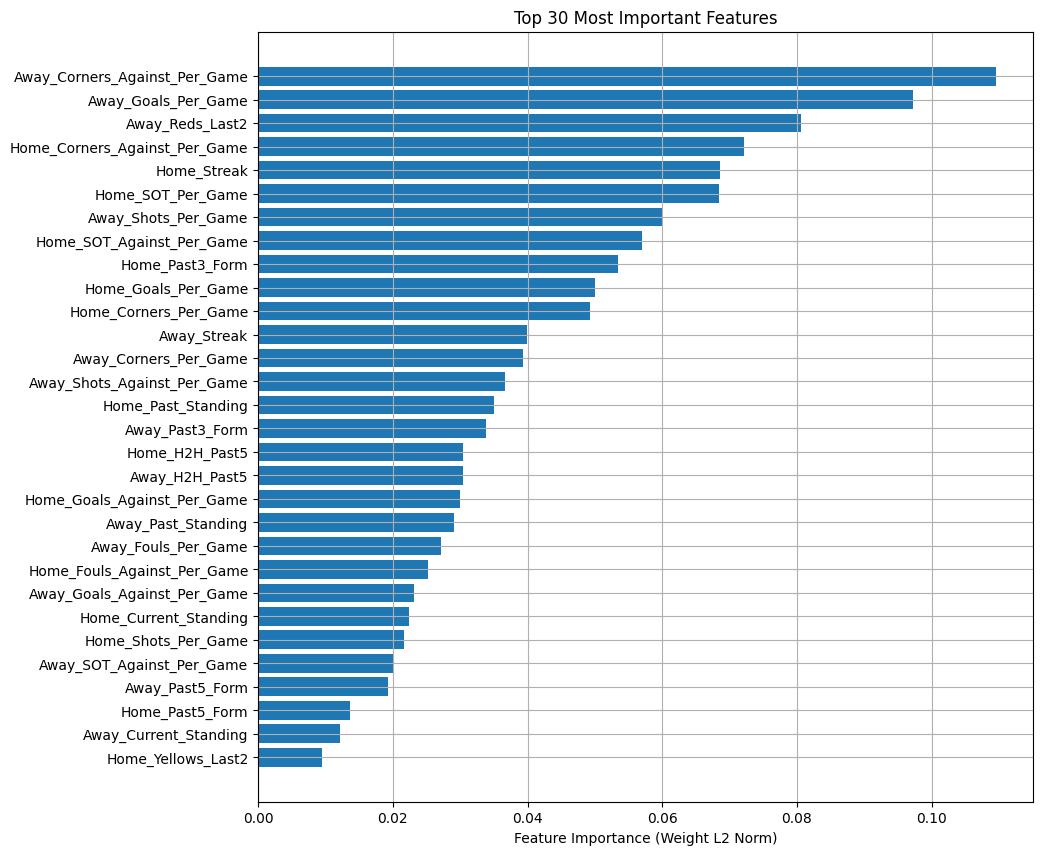

In [7]:
# Map y labels to 0, 1, 2
y_mapped = y.map({-1: 0, 0: 1, 1: 2}).astype(int)

# Cross-validation to find best C
C_values = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

best_C = None
best_score = 0

for c in C_values:
    logreg = linear_model.LogisticRegression(
        C=c,
        penalty='l2',
        solver='lbfgs',
        max_iter=3000,
        random_state=42
    )
    
    scores = cross_val_score(logreg, X_train, y_train)
    print(f"C={c}, Accuracy: {scores.mean():.4f}")

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_C = c

print(f"\nBest C: {best_C}, Best CV Score: {best_score:.4f}")

# Train final model
best_model = linear_model.LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)
best_model.fit(X_train, y_train)

# Test accuracy
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

feature_names = list(X.columns) 

# Get absolute weight importance
coef_matrix = best_model.coef_ 

# Calculate L2 norm for each feature
feature_importance = np.linalg.norm(coef_matrix, axis=0)  # shape: (number of features,)

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # descending
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot top N
N = 30
plt.figure(figsize=(10,10))
plt.barh(sorted_features[:N][::-1], sorted_importance[:N][::-1])
plt.xlabel('Feature Importance (Weight L2 Norm)')
plt.title(f'Top {N} Most Important Features')
plt.grid()
plt.show()

# Logistic Regression After PCA

In [8]:
# Cross-validation to find best C for PCA-transformed data
C_values = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50] 
best_C_pca = None
best_score_pca = 0

for c in C_values:
    logreg_pca = linear_model.LogisticRegression(
        C=c,
        penalty='l2',
        solver='lbfgs',
        max_iter=3000,
        random_state=42
    )
    scores_pca = cross_val_score(logreg_pca, X_train_pca, y_train)
    print(f"[PCA] C={c}, Accuracy: {scores_pca.mean():.4f}")

    if scores_pca.mean() > best_score_pca:
        best_score_pca = scores_pca.mean()
        best_C_pca = c

print(f"\n[PCA] Best C: {best_C_pca}, Best CV Score: {best_score_pca:.4f}")

# Train final model after PCA
best_model_pca = linear_model.LogisticRegression(
    C=best_C_pca,
    penalty='l2',
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)
best_model_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = best_model_pca.predict(X_test_pca)
test_accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"[PCA] Test Accuracy: {test_accuracy_pca:.4f}")


[PCA] C=0.005, Accuracy: 0.5152
[PCA] C=0.01, Accuracy: 0.5130
[PCA] C=0.05, Accuracy: 0.5141
[PCA] C=0.1, Accuracy: 0.5141
[PCA] C=0.5, Accuracy: 0.5141
[PCA] C=1, Accuracy: 0.5141
[PCA] C=5, Accuracy: 0.5145
[PCA] C=10, Accuracy: 0.5145
[PCA] C=50, Accuracy: 0.5145

[PCA] Best C: 0.005, Best CV Score: 0.5152
[PCA] Test Accuracy: 0.5402
